# CSC_52081_EP - Lab 02

### Main Objectives 

As per last week, we study an environment in the context of *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making). However, today we will additionally study *learning*, and bear in mind aspects of *scalability*; notably the fact that it is usually unreasonable to fully explore and evaluation all possible decisions; and it is typically unreasonable also to assume that we have full and accurate specifification of the environment dynamics (characteristics of the scenaario we are working on). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Inference as Search 

For inference in the context of multi-output and structured prediction, there is often an intractable number of possibilities; too many to enumerate in a brute force fashion. This is often the case in multi-label classification, and it can be the case in scenarios such as we looked at in Lab 01, where we have a probability tree. In that case, the probability tree was easy to enumerate, but this time we have modified the `Environment` class in `environment.py` to produce a more dense tree (namely, by allowing false-positive sound emissions); and producing longer trajectories. 

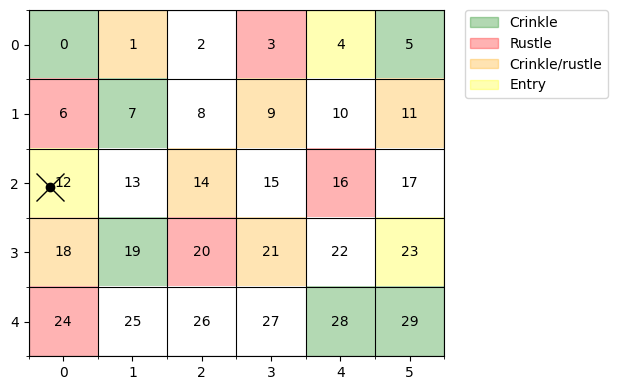

In [2]:
from environment import Environment

# Instantiate the environment
G = np.array([[1,3,0,2,4,1],
              [2,1,0,3,0,3],
              [4,0,3,0,2,0],
              [3,1,2,3,0,4],
              [2,0,0,0,1,1]])
# The fps flag allows for false positives (make sure you have the recent version of envioronment.py)
env = Environment(G,fps=True)
# Generate a single step, it should be possible to see a false positive appear
s, o = env.step()
ooo = np.array([o])
sss = np.array([s]).reshape(1,-1)
fig, ax = env.render(sss, ooo)

So, now let's take a fresh look at Lab 01, specifically the function `P_traj`. Go back to that function and make use of the `M` parameter to allow for abritrarily efficient inference; in particular via **Monte Carlo Search**. Essentially, you should sample `M` trajectories as an approximation:  
$$
    \{s^{(m)}_1,\ldots,s^{(m)}_T, p^{(m)}\}_{m=1}^M \approx P(S_1,\ldots,S_T \mid \vec{x}_1,\ldots,\vec{x}_T)
$$
You can use what is known as **ancestral sampling**, since you have access to the environment, sample $s_1 \sim P(s_1 | \vec{x}_1)$, then $s_2 \sim P(s_2 | s_1)$ and so on (similarly to how you probably did for the brute force solution, but only selecting one of the possibilities. 

Again, this is not the same as simply using `P_traj`, because we are conditioning on the observation $\vec{x}_1,\ldots,\vec{x}_T$. 

#### Task 

Reimplement `P_traj` where it should use your solution from last week when `M<0` and take `M` samples when `M>0`. 

In [3]:
# This code is to extract your solution from Lab 01, replace 'Lab_01_Solution.ipynb' as appropriate
from extracter import extract_tagged_cells
extract_tagged_cells("rafael.benzi-01.ipynb","agent.py",tags=["import numpy as np", "def gen_traj", "class Agent"])

['import numpy as np', 'def gen_traj', 'class Agent']
Extracted 3 cells with tags '['import numpy as np', 'def gen_traj', 'class Agent']' to agent.py


In [4]:
from agent import Agent, gen_traj

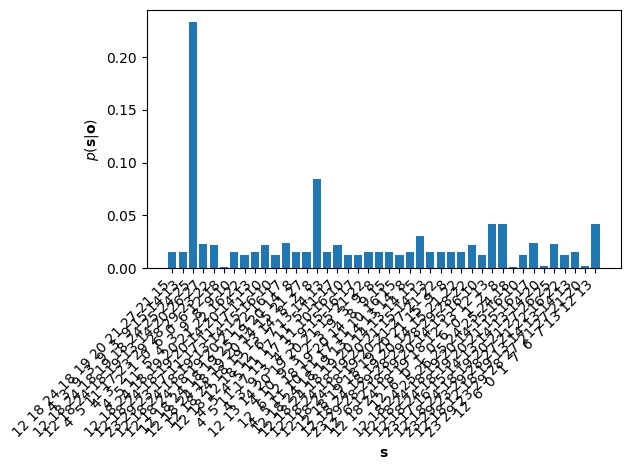

In [5]:
# Generate a trajectory
ooo, sss = gen_traj(env,10)

# Instantiate your agent
agent = Agent(env)

# Use your new implementation, by specifying M>0
P_joint = agent.P_traj(ooo, M=50)

# Create fig
plt.figure()
plt.bar(list(P_joint.keys()), list(P_joint.values()))
plt.xlabel(r"$\mathbf{s}$")
plt.ylabel(r"$p(\mathbf{s}|\mathbf{o})$")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

Discussion points: What happens if we only made a longer trajectory, but it was still sparse in probabilities? Would 'ancestral sampling' still be appropriate? 


In [6]:
# For the remainder, let's use the first version of the enviroment
env = Environment(G)

## Machine Learning for Autonomous Agents

Until now we supposed full unfettered access to the environment. But now suppose that we do *not* have access to the environment definition. Rather, we need to learn it. Suppose that we *do* have access to trajectories from the enviroment, generated by some agent interacting with it,  
$$
    \mathbf{o}_1,\ldots,\mathbf{o}_T \sim p
$$
$$
    \mathbf{a} \sim \pi(\mathbf{o}_1,\ldots,\mathbf{o}_T)
$$
where (in the following) $\mathbf{a}$ is a one-hot-encoded action, relating to the number of possible actions. 

In [7]:
# We will import pytorch
import torch
import torch.nn as nn

#### Generating data 

Let's generate data, as 
$$
    D = \{(\mathbf{o}_{1:T}, \mathbf{a}_i\}
$$
where $\mathbf{a}$ is one-hot-encoded.  

So dataset `D` will contain $n$ tuples, each containing $T$ observations (dimensionality $2$) and $T$ actions (dimensionality `n_states`). 

This is as if recording an expert agent performing in the environment. Note that we could also include directly the action taken by an agent, rather assuming the ground truth. 

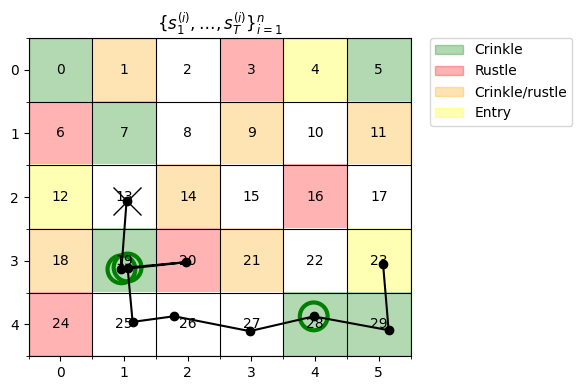

In [8]:
# Quickly visualise
T=10
ooo, sss = gen_traj(env,T)
fig, ax = env.render(sss, ooo, title=r"$\{s^{(i)}_1,\ldots,s^{(i)}_T\}_{i=1}^n$")
plt.show()

In [9]:
# Build a dataset
D = []
n_states = env.n_states
trajs = []
n = 2000
T = 15

for i in range(n):
    ooo, sss = gen_traj(env,T)
    trajs.append(sss)
    ooo = torch.tensor(ooo, dtype = torch.int64)
    sss = torch.tensor(sss, dtype = torch.int64)
    # We also have the (more realistic) option to use the expert agent's action here
    one_hot = torch.nn.functional.one_hot(sss, num_classes=n_states)
    D.append((ooo, one_hot.float()))

#### Transformers

We will be using transformers, which are excellent for sequential modelling. Have a look at the following `class`, which we will use in the following. 

In [10]:
class TinyTransformerDecoder(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16, num_layers=1, num_heads=1, max_seq_len=500):
        super(TinyTransformerDecoder, self).__init__()
        
        self.input_projection = nn.Linear(input_dim, embedding_dim)
        
        # Positional encoding
        self.positional_encoding = self._generate_positional_encoding(max_seq_len, embedding_dim)
        
        # Use TransformerEncoder with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * 2,
            dropout=0.,  # small model/dataset
            batch_first=True  # This is the key change
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_projection = nn.Linear(embedding_dim, output_dim)
        
    def _generate_positional_encoding(self, max_seq_len, embedding_dim):
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding  # Shape: (max_seq_len, embedding_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)
        
        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))
        
        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)
        
        output = self.output_projection(x_transformed)
        return output

## Imitation Learning 

Imitation learning is an alternative to reinforcement learning, for producing an autonomous agent. Rather than learn via reinforcement, we can learn to imitate an expert agent (possibly, a human) that has already solved a given task. 

In this case, we would suppose that the agent which has generated the trajectories in data set `D` is such an expert. 

Specifically, in imitation learning (and in this example), we seek
$$
    \mathbf{a}_t = \pi(\mathbf{o}_1, \ldots, \mathbf{o}_t)
$$ 
where $\pi$ the policy of the agent, that maps inputs to an action. 

In the case of the Environment studied in Lab 01, is it clear why we should consider the full history of observations? 

In [11]:
input_dim = 2
output_dim = n_states
embedding_dim = 16
num_layers = 1
num_heads = 1
seq_length = 6
batch_size = 32

#### Task 

Use the `TinyTransformerDecoder` defined above to complete the Imitation Learning task in the cell below.

**Important** Do not remove the first comment from the cell `# TASK 2 IMITATION LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

In [12]:
# TASK 2 IMITATION LEARNING

model_il = TinyTransformerDecoder(input_dim, output_dim, embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads)
dataloader = torch.utils.data.DataLoader(D, batch_size=batch_size, shuffle=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_il.parameters(), lr=0.001)

# Total number of epochs
num_epochs = 500

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//2, gamma=0.1)

# Training loop
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs+1):
    model_il.train()
    running_loss = 0.0
    for observations, actions in dataloader:
        optimizer.zero_grad()
        outputs = model_il(observations.float())
        loss = criterion(outputs.view(-1, output_dim), actions.view(-1, output_dim).argmax(dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
    
    # Save the model state if it has the lowest loss so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_state = model_il.state_dict()

    # Step the scheduler
    scheduler.step()

# Load the best model state
if best_model_state is not None:
    model_il.load_state_dict(best_model_state)

c:\Python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0/500, Loss: 3.302168641771589
Epoch 100/500, Loss: 1.4923573524232894
Epoch 200/500, Loss: 1.4625515881038846
Epoch 300/500, Loss: 1.440282942756774
Epoch 400/500, Loss: 1.4389704598320856
Epoch 500/500, Loss: 1.4352082960189334


### Evaluation

How well is our model (agent) performing (the one learned via imitation learning)?

In the following, we deploy the agent and test it, in a similar way to Lab 01 (on the same environment). 

First, we wrap the model inference in the `act` function of an Agent class (namely, `DTAgent` below), so we can compare. 

#### Task

Complete the `act` function in the `DTAgent` class below to return an integer indicating the action, as per the description of the scenario given already in Lab 01. 

Hint: to get probabilities, use `torch.softmax(outputs, axis = 2)`

In [13]:
class DTAgent:

    def act(self,ooo):
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

        ooo : array_like(int,ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        a : int
            the chosen action a, it should be one of the n_states
        '''

        # Predict
        input_tensor = torch.tensor(ooo, dtype=torch.float32).unsqueeze(0)  
        model_il.eval()
        with torch.no_grad():
            outputs = model_il(input_tensor)
            probabilities = torch.softmax(outputs, axis = 2)
            action_probabilities = probabilities[:, -1, :]
            action = torch.argmax(action_probabilities).item()
        return action

In the following, we perform the evaluation. 

In [14]:
# Instantiate the agent
dt_agent = DTAgent()
n_test = 1000
T_test = 6
score = 0

for i in range(n_test): 
    oooo, ssss = gen_traj(env,T_test)
    oooo = torch.tensor(oooo, dtype = torch.float32)
    a_t = dt_agent.act(oooo)
    score += env.rwd(a_t,ssss[-1])
score = score/n_test
print(f"Model Prediction: {score*100}%")

C:\Users\rafin\AppData\Local\Temp\ipykernel_13436\2447226717.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(ooo, dtype=torch.float32).unsqueeze(0)


Model Prediction: 41.9%


## Model Learning

Imitation Learning in the real world can be a bit risky. If we had a *model* of the environment, we could 'practice'. Namely, we seek
$$
    \mathbf{x}_{t+1} \sim P(\mathbf{x}_{t+1} | \mathbf{x}_1, \ldots, \mathbf{x}_t)
$$ 

With this we could generate trajectories, with which to safely train an agent in simulation. 

In [15]:
input_dim = 2
output_dim = 2
embedding_dim = 16
num_layers = 1
num_heads = 1
seq_length = 6
batch_size = 32

#### Task 

Use the `TinyTransformerDecoder` to complete the Model Learning task in the cell below. Again, do not replace or remove the `TASK` tag.

Then, complete the `sample_next_obs` function of the `DTEnvironment` class to sample 

**Important** Do not remove the first comment from the cell `# TASK 3 MODEL LEARNING` as it will help us locate your implementation. 

**Important** Your configuration should complete in less than 5 minutes on a personal laptop machine (noting that 2 minutes should be more than enough)

In [16]:
# TASK 3 MODEL LEARNING
model_ml = TinyTransformerDecoder(input_dim, output_dim, embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads)
dataloader = torch.utils.data.DataLoader(D, batch_size=batch_size, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ml.parameters(), lr=0.00005)

# Total number of epochs
num_epochs = 1000

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//2, gamma=0.1)

# Training loop
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs+1):
    model_ml.train()
    running_loss = 0.0
    for observations, actions in dataloader:
        optimizer.zero_grad()
        outputs = model_ml(observations.float())
        loss = criterion(outputs.view(-1, output_dim), observations.view(-1, output_dim).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss}")
    
    # Save the model state if it has the lowest loss so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_state = model_ml.state_dict()

    # Step the scheduler
    scheduler.step()

# Load the best model state
if best_model_state is not None:
    model_ml.load_state_dict(best_model_state)


Epoch 0/1000, Loss: 0.7081659956583901

c:\Python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Epoch 100/1000, Loss: 8.662636779869597e-05
Epoch 200/1000, Loss: 5.511460484639328e-06
Epoch 300/1000, Loss: 9.228344103417291e-07
Epoch 400/1000, Loss: 3.132339877141469e-07
Epoch 500/1000, Loss: 1.641947110762149e-07
Epoch 600/1000, Loss: 1.411615994042915e-07
Epoch 700/1000, Loss: 1.2592564784217612e-07
Epoch 800/1000, Loss: 1.1097805730471356e-07
Epoch 900/1000, Loss: 9.900110361134769e-08
Epoch 1000/1000, Loss: 8.636016566415925e-08


In [17]:
class DTEnvironment:

    def sample_next_obs(self,ooo):
        '''
        Provide a next observation, to follow the provided observation. 

        Parameters
        ----------

        ooo : array_like(ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        o : array_like(ndim=1)
            the next observation as an array of 2 ints
        '''

        input_tensor = torch.tensor(ooo, dtype=torch.float32)

        model_ml.eval()
        with torch.no_grad():  # Disable gradient comp for inference
            obs = model_ml(input_tensor.unsqueeze(0))
        obs = torch.sigmoid(obs)

        # Extract the next observation
        final_obs = obs[:, -1, :]
        
        return torch.bernoulli(final_obs).int().numpy()

Once we have a model of the environment, we can simulate new trajectories, as exemplified as follows. 

In [20]:
dt_env = DTEnvironment()
# Generate some trajectories from the environment 
T=9
oooo = np.zeros((T,2))
for t in range(1,T):
    out = dt_env.sample_next_obs(oooo[0:t,:])
    oooo[t,:] = dt_env.sample_next_obs(oooo[0:t,:])

print(oooo)

[[0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]]


You can use your `p_traj` function to check the 'legitimacy' of these trajectories (they should have probability greater than 0). 

Of course, in a real-world environment, validating the trajectories is more subjective, or requires human expertise. 
# 

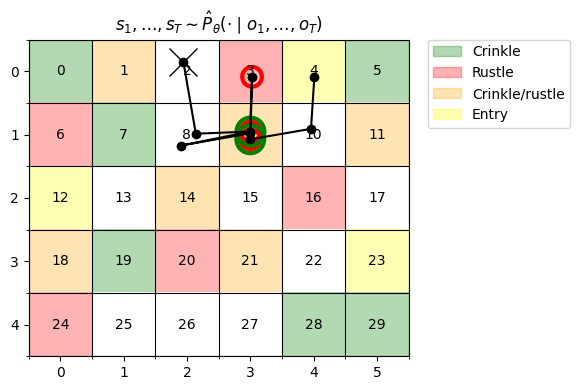

In [21]:
agent = Agent(env)
P_joint = agent.P_traj(oooo.astype(int))

# Check should sum to 1 (or close enough)
probs = list(P_joint.values())
assert abs(sum(probs) - 1) <= 0.05

# Extract possible paths
paths = [np.fromstring(k, sep=' ') for k in P_joint.keys()] 

# Take some samples
sample_indices = np.random.choice(len(probs), size=10, p=probs)
trajs = [paths[i].astype(int) for i in sample_indices]

# Visualise 
fig, ax = env.render(trajs[0], oooo, title=r"$s_1,\ldots,s_T \sim \hat P_\theta(\cdot \mid o_1,\ldots,o_T)$")
plt.show()

## A Shared Representation

Notice that both the previous tasks (imitation learning and model learning) have something in common; namely the input. It suggests it may be more efficient to share a representation in a deep architecture, rather than reimplementing both as separate networks. Such architectures will also be very useful later for reinforcement learning. 

Have a look at the architecture defined in the following. 

In [ ]:
class TinyTransformerDecoderDoubleHead(nn.Module):
    def __init__(self, input_dim, act_dim, obs_dim, embedding_dim=16, num_layers=1, num_heads=1, max_seq_len=500):
        super(TinyTransformerDecoderDoubleHead, self).__init__()
        
        self.input_projection = nn.Linear(input_dim, embedding_dim)
        
        # Positional encoding
        self.positional_encoding = self._generate_positional_encoding(max_seq_len, embedding_dim)
        
        # Use TransformerEncoder with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * 2,
            dropout=0.,  # small model/dataset
            batch_first=True  # This is the key change
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.act_projection = nn.Linear(embedding_dim, act_dim)
        self.obs_projection = nn.Linear(embedding_dim, obs_dim)
        
    def _generate_positional_encoding(self, max_seq_len, embedding_dim):
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pos_encoding = torch.zeros(max_seq_len, embedding_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding  # Shape: (max_seq_len, embedding_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x_emb = self.input_projection(x)
        
        # Add positional encoding
        pos_encoding = self.positional_encoding[:x.size(1), :].to(x.device)
        x_emb = x_emb + pos_encoding

        # Generate causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1))
        
        # Use mask in the encoder
        x_transformed = self.transformer(x_emb, mask=causal_mask)
        
        act = self.act_projection(x_transformed)
        obs = self.obs_projection(x_transformed)
        return act, obs

In [ ]:
input_dim = 2
act_dim = 30
obs_dim = 2
embedding_dim = 16
num_layers = 1
num_heads = 1
seq_length = 6
batch_size = 32

#### Task 

Implement the Architecture in PyTorch using a double head (and shared inner representations). 

In [ ]:
# TASK 4 SHARED REPRESENTATION 
model_shared = TinyTransformerDecoderDoubleHead(input_dim, act_dim, obs_dim, embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads)
dataloader = torch.utils.data.DataLoader(D, batch_size=batch_size, shuffle=True)

# Define the loss functions and optimizer
criterion_act = nn.CrossEntropyLoss()
criterion_obs = nn.MSELoss()
optimizer = torch.optim.Adam(model_shared.parameters(), lr=0.0001)

# Total epochs
num_epochs = 1000

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//2, gamma=0.1)

# Training loop
best_loss_act = float('inf')
best_loss_obs = float('inf')
best_model_state = None

for epoch in range(num_epochs+1):
    model_shared.train()
    running_loss_act = 0.0
    running_loss_obs = 0.0
    for observations, actions in dataloader:
        optimizer.zero_grad()
        outputs_act, outputs_obs = model_shared(observations.float())
        loss_act = criterion_act(outputs_act.view(-1, act_dim), actions.view(-1, act_dim).argmax(dim=1))
        loss_obs = criterion_obs(outputs_obs.view(-1, obs_dim), observations.view(-1, obs_dim).float())
        loss = loss_act + loss_obs
        loss.backward()
        optimizer.step()
        running_loss_act += loss_act.item()
        running_loss_obs += loss_obs.item()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss Act: {running_loss_act/len(dataloader)}, Loss Obs: {running_loss_obs/len(dataloader)}")

    epoch_loss_act = running_loss_act / len(dataloader)
    epoch_loss_obs = running_loss_obs / len(dataloader)
    
    # Save the model state if it has the lowest loss so far
    if epoch_loss_act < best_loss_act and epoch_loss_obs < best_loss_obs:
        best_loss_act = epoch_loss_act
        best_loss_obs = epoch_loss_obs
        best_model_state = model_shared.state_dict()

    # Step the scheduler
    scheduler.step()

# Load the best model state
if best_model_state is not None:
    model_shared.load_state_dict(best_model_state)

Epoch 1/1000, Loss Act: 3.6440165118565635, Loss Obs: 0.5459794047332945
Epoch 101/1000, Loss Act: 2.1427457711053273, Loss Obs: 0.001754834651133962
Epoch 201/1000, Loss Act: 1.6340184722627913, Loss Obs: 0.0032169645992181604
Epoch 301/1000, Loss Act: 1.5802158930945018, Loss Obs: 0.002059250305007611
Epoch 401/1000, Loss Act: 1.563389257779197, Loss Obs: 0.0019273211152130176
Epoch 501/1000, Loss Act: 1.5495291475265744, Loss Obs: 0.0017414527449993388
Epoch 601/1000, Loss Act: 1.5478370908706907, Loss Obs: 0.0017176960347338565
Epoch 701/1000, Loss Act: 1.5470079107890053, Loss Obs: 0.0017082822668026128
Epoch 801/1000, Loss Act: 1.5450919355664934, Loss Obs: 0.0017036564725761612
Epoch 901/1000, Loss Act: 1.544466154915946, Loss Obs: 0.0017093630832812144
Epoch 1001/1000, Loss Act: 1.5435507165061102, Loss Obs: 0.001711410357587276
